# Individual Project Second Draft

We'll do something more here...
- Import a dataset of people
- According to the labels on the dataset, attach an adversarial patch on the people

In [ ]:
# pip install tensorflow_dataset

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

## Load dataset from TFDS

In [ ]:
dataset = tfds.load('coco/2017', split='train', data_dir='/content/tensorflow_datasets')

## Creating the adversarial patch

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# To-do: Data type should be floating number or integer??
random = tf.random.Generator.from_seed(1)
adversarial_patch = random.uniform(shape=(1, 100, 100, 3), minval=0, maxval=255, dtype=tf.dtypes.int32)

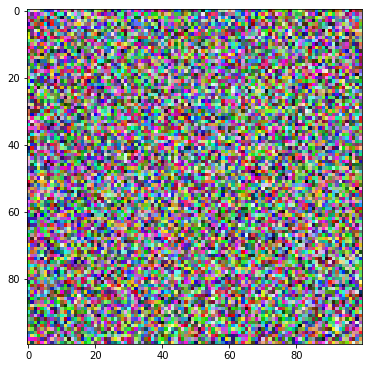

In [ ]:
plt.figure(figsize=(6,8))
plt.imshow(adversarial_patch[0])
plt.show()

## Fetch dataset class labels

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
from object_detection.utils import label_map_util

%matplotlib inline

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

for category in category_index:
  if category_index[category]['name'] == 'person':
    person_class_index = category_index[category]['id']
    print("A person class index is: " + str(person_class_index) + ".\n")
    break

for index in category_index.items():
  (x, y) = index
  print("ID: " + str(y['id']) + ", Name: " + y['name'])

## Display an example from the dataset

In [ ]:
dataset2 = dataset.take(5)

In [ ]:
data2 = list(dataset2)[4]

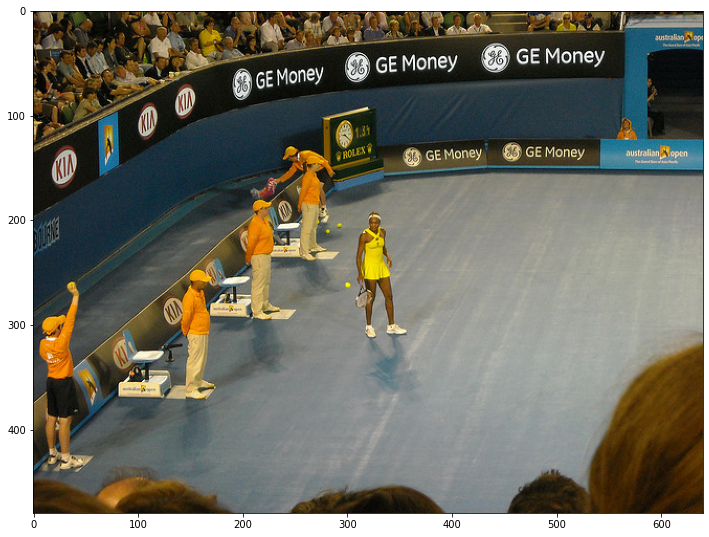

In [ ]:
plt.figure(figsize=(12,16))
plt.imshow(data2['image'])
plt.show()

In [ ]:
from object_detection.utils import visualization_utils as viz_utils

In [ ]:
label_id_offset = 1

image_with_detections = data2['image'].numpy()
image_objects_bbox = data2['objects']['bbox'].numpy()
image_objects_label = data2['objects']['label'].numpy() + label_id_offset
number_of_detection = data2['objects']['label'].get_shape().as_list()[0]
image_objects_score = tf.ones([number_of_detection]).numpy()

# Debug:
print(image_objects_label - label_id_offset)

[32 32 32 32 74 56 56 38  0  0  0  0  0  0  0  0  0  0 56 56  0  0  0  0]


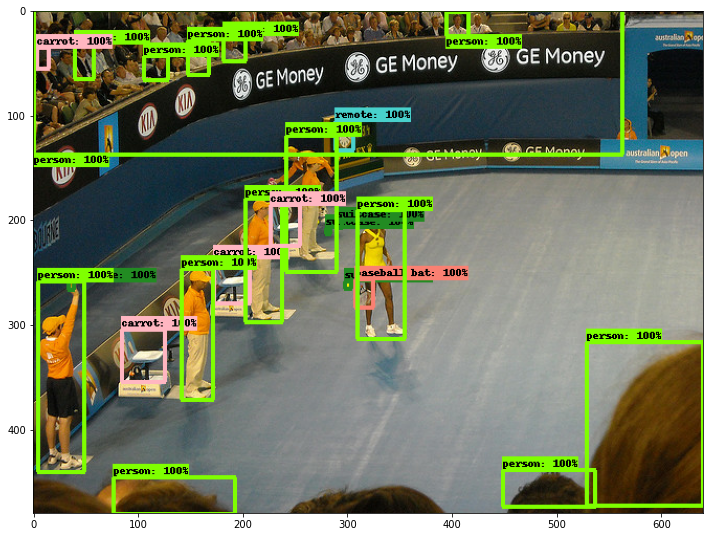

In [ ]:
(image_length, image_width, _) = image_with_detections.shape
for bbox in image_objects_bbox:
  bbox[0] *= image_length
  bbox[1] *= image_width
  bbox[2] *= image_length
  bbox[3] *= image_width

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      image_objects_bbox,
      image_objects_label, 
      image_objects_score,
      category_index,
      max_boxes_to_draw=50)

plt.figure(figsize=(12,16))
plt.imshow(image_with_detections)
plt.show()

## Attach adversarial patch to the examples

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
# Attach a patch on the bounding box within in image
# Takes in numpy variable, return numpy variable
def attach_adversarial_patch(img, bounding_box, patch):
  IMG_RATIO = 0.5
  # IMG_ROTATION = 0.0
  # IMG_BRIGHTNESS = 0.0

  (img_length, img_width, _) = img.shape

  ymin = int(bounding_box[0] * img_length)
  xmin = int(bounding_box[1] * img_width)
  ymax = int(bounding_box[2] * img_length)
  xmax = int(bounding_box[3] * img_width)

  bbox_length = ymax - ymin
  bbox_width = xmax - xmin

  # Convert image to PIL Image object
  img = Image.fromarray(img)
  patch = Image.fromarray(patch)

  # Resize patch to fit in the box
  if bbox_width < bbox_length:
    patch_size = int(bbox_width * IMG_RATIO)
  else:
    patch_size = int(bbox_length * IMG_RATIO)

  patch = patch.resize((patch_size, patch_size))

  # Attach the patch to bounding box
  xstart = int(xmax - bbox_width/2 - patch_size/2)
  ystart = int(ymax - bbox_length/2 - patch_size/2)
  img.paste(patch, (xstart, ystart))

  return np.array(img)

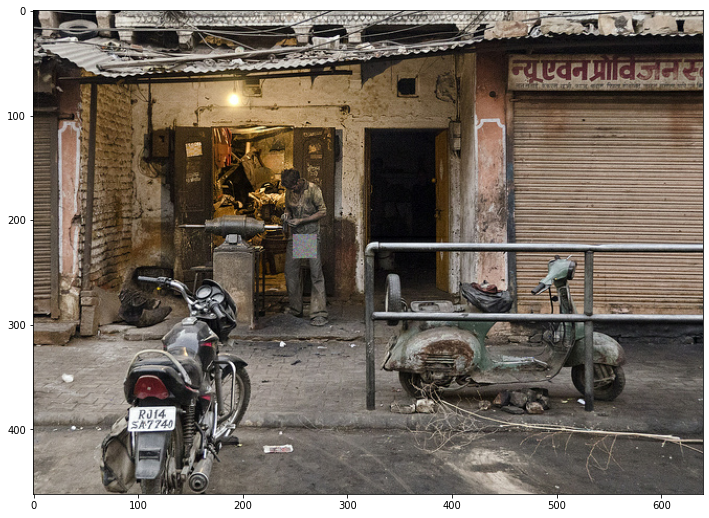

In [ ]:
# Testing the function on a sample
dataset3 = dataset.take(1)

for data3 in dataset3:

  number_of_detection = data3['objects']['label'].get_shape().as_list()[0]
  for d in range(number_of_detection):
    if data3['objects']['label'][d] + label_id_offset == person_class_index:
      image = data3['image'].numpy()
      image_objects_bbox = data3['objects']['bbox'][d].numpy()
      adversarial_patch_np = tf.cast(adversarial_patch, dtype=tf.uint8).numpy()[0]

      new_image = attach_adversarial_patch(image, image_objects_bbox, adversarial_patch_np)

      plt.figure(figsize=(12,16))
      plt.imshow(new_image)
      plt.show()

## Create dataset mapping function

In [ ]:
def map_adv_patch_to_dataset(img, imgfilename, imgid, area, bbox, id, is_crowd, label, adversarial_patch):
  person_class_index = 1
  label_id_offset = 1

  num_of_detection = label.get_shape().as_list()[0]

  new_img = img.numpy()
  patch = tf.cast(adversarial_patch, dtype=tf.uint8).numpy()[0]

  for detection in range(num_of_detection):
    if label[detection] + label_id_offset == person_class_index and is_crowd[detection] == False:
      new_img = attach_adversarial_patch(new_img,
                                     bbox[detection].numpy(),
                                     patch)
  
  new_img = tf.convert_to_tensor(new_img)
  return (new_img, imgfilename, imgid, area, bbox, id, is_crowd, label)

def deconstruct_dict_and_mapping(img, imgfilename, imgid, area, bbox, id, is_crowd, label, adversarial_patch):
  element = map_adv_patch_to_dataset(img, imgfilename, imgid, area, bbox, id, is_crowd, label, adversarial_patch)

  return element

# Workaround to return a dictionary to the dataset mapping function
def reconstruct_dict(img, imgfilename, imgid, area, bbox, id, is_crowd, label):
  return {'image': img,
          'image/filename': imgfilename,
          'image/id': imgid,
          'objects': {
              'area': area,
              'bbox': bbox,
              'id': id,
              'is_crowd': is_crowd,
              'label': label
          }}

In [ ]:
dataset4 = dataset.take(5)

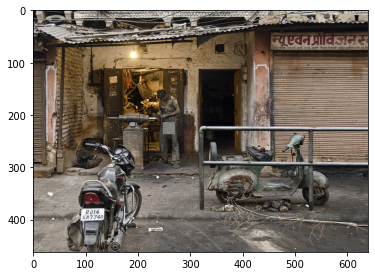

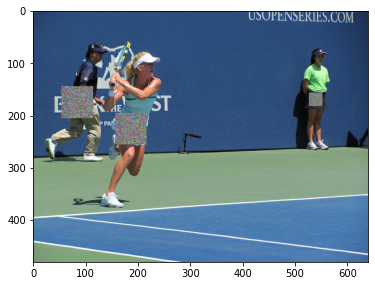

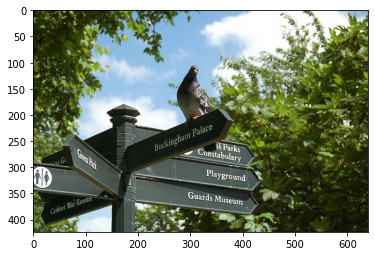

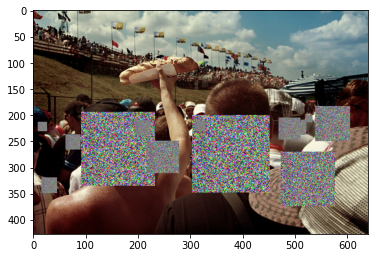

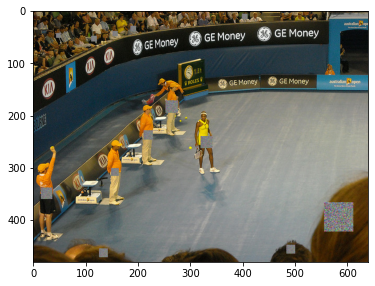

In [ ]:
element_type_list = (tf.uint8, tf.string, tf.int64, tf.int64, tf.float32, tf.int64, tf.bool, tf.int64)

dataset4_mapped = dataset4.map(lambda x : tf.py_function(func=deconstruct_dict_and_mapping, 
                                                         inp=[x['image'], 
                                                              x['image/filename'], 
                                                              x['image/id'],
                                                              x['objects']['area'],
                                                              x['objects']['bbox'],
                                                              x['objects']['id'],
                                                              x['objects']['is_crowd'],
                                                              x['objects']['label'],
                                                              adversarial_patch], 
                                                         Tout=element_type_list)).map(reconstruct_dict)

for data4 in dataset4_mapped:
  plt.figure(figsize=(6, 8))
  plt.imshow(data4['image'].numpy())
  plt.show()